In [1]:
import pandas as pd
import numpy as np
from typing import (List, Tuple, Dict, Union)
from data_service import (get_shibor_data, get_interpld_shibor,
                          query_china_shibor_all)

from scr.calc_func import CVIX,prepare_data2calc


本篇算法来源：
>《20180707_东北证券_金融工程_市场波动风险度量：vix与skew指数构建与应用》

In [2]:
opt_data = pd.read_csv('opt_data.csv', index_col=[0])

shibor_df = get_shibor_data('2015-02-09', '2022-05-27')
# 插值
interpld_shibor = get_interpld_shibor(shibor_df)

In [3]:
data_all = prepare_data2calc(opt_data,interpld_shibor)

In [4]:
vix_func = CVIX(data_all)

d:\WrokSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:167: UserWarning: F:2.7309,strike_marix中最小执行价为:2.7500,故开跌部分无数据,无中间价K0.
  warnings.warn('F:%.4f,strike_marix中最小执行价为:%.4f,故开跌部分无数据,无中间价K0.' %
d:\WrokSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:167: UserWarning: F:2.7550,strike_marix中最小执行价为:2.8000,故开跌部分无数据,无中间价K0.
  warnings.warn('F:%.4f,strike_marix中最小执行价为:%.4f,故开跌部分无数据,无中间价K0.' %
d:\WrokSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:167: UserWarning: F:2.4662,strike_marix中最小执行价为:2.5000,故开跌部分无数据,无中间价K0.
  warnings.warn('F:%.4f,strike_marix中最小执行价为:%.4f,故开跌部分无数据,无中间价K0.' %
d:\WrokSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:167: UserWarning: F:2.4619,strike_marix中最小执行价为:2.5000,故开跌部分无数据,无中间价K0.
  warnings.warn('F:%.4f,strike_marix中最小执行价为:%.4f,故开跌部分无数据,无中间价K0.' %
d:\WrokSpace\Quantitative-analysis\C-择时类\C-VIX中国版VIX编制手册\scr\calc_func.py:167: UserWarning: F:2.3890,strike_marix中最小执行价为:2.4000,故开跌部分无数据,无中间价K0.

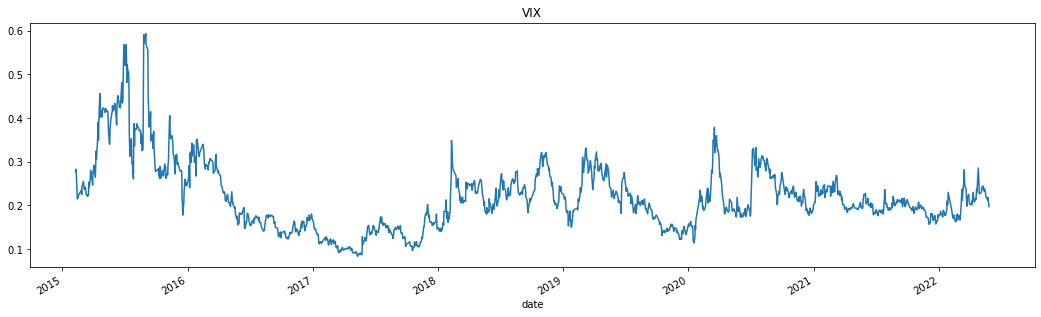

In [7]:
vix:pd.Series = vix_func.vix()
vix.plot(figsize=(18,5),title='VIX');

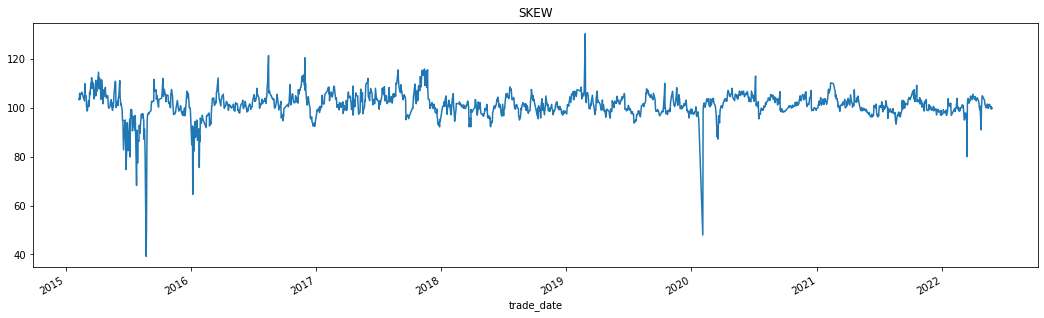

In [8]:
skew:pd.Series = vix_func.skew()
skew.plot(figsize=(18,5),title='SKEW');